In [6]:
#Brendan McCabe
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import math
import random

In [2]:
def soft_k_means(data, theta, alpha, annealing, sigma):
    s = 100000 #temp, 1/beta
    s_thresh = 1
    bounds = [max(data[0]), min(data[0]), max(data[1]), min(data[1])]
    cluster_centers = [[random.randint(np.ceil(bounds[1]),np.floor(bounds[0]) + 1)],\
                       [random.randint(np.ceil(bounds[3]),np.floor(bounds[2]) + 1)]]
    initial = [cluster_centers[0][0], cluster_centers[1][0]]
    pcx = []
    pxc = []
    for i in range(len(data[0])):
        pcx.append([0.5])
    pc = []
    iterations = []
    while s > s_thresh:
        old_centers = [[],[]]
        cluster_centers, pcx = split(cluster_centers, pcx, sigma, bounds)
        curr_iteration = 0
        while not convergence(cluster_centers, old_centers, theta):
            pc = calc_pc(pcx)
            pcx = calc_pcx(data, cluster_centers, pc, s)
            pxc = calc_pxc(pcx, pc)
            old_centers = cluster_centers.copy()
            cluster_centers = calc_centers(data, pxc)
            curr_iteration += 1
        cluster_centers, pcx = merge_centers(cluster_centers, alpha, pcx)
        s = s * annealing
        iterations.append(curr_iteration)
    pc = calc_pc(pcx)
    pcx = calc_pcx(data, cluster_centers, pc, s)
    return cluster_centers, pcx, iterations, initial

In [3]:
def merge_centers(cluster_centers, alpha, pcx):
    merged_pcx = []
    for i in range (len(pcx)):
        merged_pcx.append([])
    merged_centers = [[],[]]
    remove = []
    for i in range(len(cluster_centers[0]) - 1):
        for j in range(i+1,len(cluster_centers[0])):
            if j not in remove:
                dist = distance([cluster_centers[0][i], cluster_centers[1][i]], [cluster_centers[0][j], cluster_centers[1][j]])
                if dist < alpha:
                    remove.append(j)
    for i in range(len(cluster_centers[0])):
        if i not in remove:
            for j in range(len(pcx)):
                merged_pcx[j].append(pcx[j][i])
            merged_centers[0].append(cluster_centers[0][i])
            merged_centers[1].append(cluster_centers[1][i])
    return merged_centers, merged_pcx

def split(cluster_centers, pcx, sigma, bounds):
    for i in range(len(pcx)):
        for j in range(len(cluster_centers[0])):
            pcx[i].append(pcx[i][j])
    for i in range(len(cluster_centers[0])):
        next_x = cluster_centers[0][i] + random.uniform(-sigma, sigma)
        next_y = cluster_centers[1][i] + random.uniform(-sigma, sigma)
        next_x = min(next_x, bounds[0])
        next_x = max(next_x, bounds[1])
        next_y = min(next_y, bounds[2])
        next_y = max(next_y, bounds[3])
        cluster_centers[0].append(next_x)
        cluster_centers[1].append(next_y)
    return cluster_centers, pcx

def distance(point1, point2):
    return np.sqrt(np.power(point1[0] - point2[0], 2) + np.power(point1[1] - point2[1], 2))

def calc_pc(pcx):
    pcs = []
    for i in range (len(pcx[0])):
        next_pc = 0
        for j in range (len(pcx)):
            next_pc += pcx[j][i]
        pcs.append(next_pc / len(pcx))
    return pcs

def calc_pcx(data, cluster_centers, pc, s):
    pcxs = []
    for i in range (len(data[0])):
        next_pcx = []
        for j in range(len(cluster_centers[0])):
            dist = (distance([data[0][i], data[1][i]], [cluster_centers[0][j], cluster_centers[1][j]]))
            distortion = pow(dist, 2)
            e_exp = np.power(math.e, (-1/s) * dist)
            total = 0
            for m in range(len(pc)):
                dist_sum = (distance([data[0][i], data[1][i]], [cluster_centers[0][m], cluster_centers[1][m]]))
                distortion_sum = pow(dist_sum,2)
                total += pc[m] * math.exp((-1/s) * dist_sum)
            if total == 0:
                next_pcx.append(0)
            else:
                next_pcx.append(pc[j] * e_exp / total)
        pcxs.append(next_pcx)
    return pcxs

def calc_pxc(pcx, pc):
    pxcs = []
    for i in range (len(pc)):
        next_pxc = []
        for j in range (len(pcx)):
            total = 0
            for m in range (len(pcx)):
                total += pcx[m][i]
            if total == 0:
                next_pxc.append(0)
            else:
                next_pxc.append(pcx[j][i]/ total)
        pxcs.append(next_pxc)
    return pxcs


def calc_centers(data, pxc):
    centers = [[],[]]
    for i in range (len(pxc)):
        total = [0,0]
        for j in range (len(data[0])):
            total = [total[0] + pxc[i][j] * data[0][j],total[1] + pxc[i][j] * data[1][j]]
        if total != 0:
            centers[0].append(total[0])
            centers[1].append(total[1])
    return centers

def convergence(cluster_centers, old_centers, theta):
    if len(old_centers[0]) == 0:
        return False
    for i in range (len (cluster_centers[0])):
        point1 = [cluster_centers[0][i], cluster_centers[1][i]]
        point2 = [old_centers[0][i], old_centers[1][i]]
        if(distance(point1, point2) > theta):
            return False
    return True

In [4]:
def generate_data(mean, dev, count):
    gen_x = np.random.normal(mean[0], dev, count)
    gen_y = np.random.normal(mean[1], dev, count)
    return [gen_x, gen_y]

def plot_data(data, color, size, centroid):
    if centroid: 
        plt.scatter(data[0], data[1], c=color, s=size, marker="*", edgecolors= "black")
    else:
        plt.scatter(data[0], data[1], c=color, s=size)
    plt.xlim([0,max(data[0] + 30)])
    plt.ylim([0,max(data[1] + 30)])
    
    
def get_centroid_colors(centroids):
    centers = []
    jump = 1
    level = 1
    centroid_colors = []
    current_color = 1
    counter = 0
    for i in range (len(centroids[0])):
        for at_level in range (3 * level):
            centroid_colors.append(decode_color(current_color))
            current_color += jump
            counter += 1
            if(counter >= len(centroids[0])):
                return centroid_colors
        if i != 0:
            jump /=2
            level += 1
        current_color = jump / 2
    return centroid_colors

def get_data_colors(centroid_colors, pcx):
    data_colors = []
    for i in range (len(pcx)):
        next_color = [0,0,0]
        for j in range(len(centroid_colors)):
            next_red = pcx[i][j] * centroid_colors[j][0]
            next_blue = pcx[i][j] * centroid_colors[j][1]
            next_yellow = pcx[i][j] * centroid_colors[j][2]
            next_color = [next_color[0]+next_red, next_color[1]+next_blue, next_color[2]+next_yellow]
        next_color = [min(1, next_color[0]), min(1, next_color[1]), min(1, next_color[2])]
        data_colors.append(next_color)
    return data_colors

def decode_color(color):
    red = 0
    blue = 0 
    yellow = 0
    if color > 2:
        yellow += color - 2
        blue += 1 - yellow
    else: 
        if color > 1:
            blue += color - 1
            red = 1 - blue
        else:
            red = color
            yellow = 1 - red
    return[red, blue, yellow]

Iterations:  22
Initial location:  [56, 133]


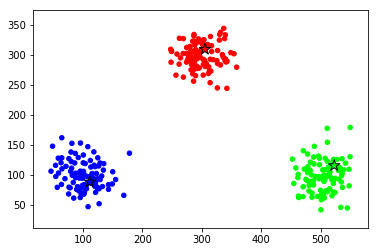

In [5]:
generated2 = generate_data([100, 100], 25, 100)
generated3 = generate_data([500, 100], 25, 100)
generated = generate_data([300, 300], 25, 100)
data_generated = [generated[0].tolist(), generated[1].tolist()]
data_generated2 = [generated2[0].tolist(), generated2[1].tolist()]
data_generated3 = [generated3[0].tolist(), generated3[1].tolist()]
mean1 = [np.mean(generated[0]), np.mean(generated[1])]
mean2 = [np.mean(generated3[0]), np.mean(generated3[1])]
middle = [(mean1[0] + mean2[0]) / 2, (mean1[1] + mean2[1]) / 2]
for i in range (len(data_generated2[0])):
    data_generated[0].append(data_generated2[0][i])
    data_generated[1].append(data_generated2[1][i])
for i in range (len(data_generated3[0])):
    data_generated[0].append(data_generated3[0][i])
    data_generated[1].append(data_generated3[1][i])
#data_generated[0].append(middle[0])
#data_generated[1].append(middle[1])
generated = np.array(data_generated)
                       #soft_k_means(data, theta, alpha, annealing, sigma):
cent, pcx, iterations, initial = soft_k_means(generated, 25, 50, .4, 25)
cent = np.array(cent)
cent_x = cent[0]
cent_y = cent[1]
print("Iterations: ", sum(iterations))
print("Initial location: ", initial)

centroid_colors = get_centroid_colors(cent)
data_colors = get_data_colors(centroid_colors, pcx)
plot_data(generated, data_colors, 20, 0)
plot_data([cent_x, cent_y], centroid_colors, 140, 1)
plt.xlim([min(generated[0] - 30),max(generated[0] + 30)])
plt.ylim([min(generated[1] - 30),max(generated[1] + 30)])

plt.show()
